
## Chapter 2 [Diffraction](Ch3-_Diffraction.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Basic Crystallography
## Real and Reciprocal Lattice

part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes



## Load relevant python packages

Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
* three dimensional plotting
and some libraries from the book
* kinematic scattering library.

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook

# 3D plotting package 
from mpl_toolkits.mplot3d import Axes3D # 3D plotting


# Import libraries from the book
import pyTEMlib
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library
                             # with Atomic form factors from Kirklands book

Populating the interactive namespace from numpy and matplotlib
Using KinsCat library version  0.5  by G.Duscher
Symmetry functions of spglib enabled



## Define graphite crystal

A crystal is well defined by its unit cell and the atom positions within, the so called base.

The unit cell fills the volume completely when translated in all three directions. Placing the unit cell in a global carthesian coordination system, we need the length of the sides and their angles for a complete description. This is depicted in the graph below.
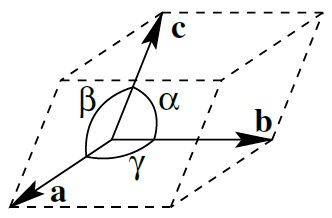

Figure taken from the wikipedia page on lattice constants.

Mathematically it is more advantageous to describe the unit cell as matrix, the
## Structure Matrix

This matrix consists of rows of vectors that span the unit cell:
$\begin{bmatrix}
  a_1 & a_2 & a_3 \\
  b_1 & b_2 & b_3 \\
  c_1 & c_2 & c_3 \\
\end{bmatrix} =\left[\vec{a},\vec{b},\vec{c}\right]$.

This structure matrix is also used to describe the super cells in materials simulations for example density functional theory.

The representation of unit cells as structure matrices allows also for easy conversions as we will see in the following.


In [2]:
#Initialize the dictionary for all the input
tags = {}

# Create graphite unit cell (or structure matrix)
a = b = 0.246 #nm
c = 0.671
gamma = 60
alpha = beta = 90

## Create the structure matrix for a hexagonal system explicitly:
tags['unit_cell'] = np.array([[a,0.,0.],  ## also called the structure matrix
                    [np.cos(np.radians(gamma))*a,np.sin(np.radians(gamma))*a,0. ],
                     [0.,0.,c]
                    ])
print('structure matrix \n',np.round(tags['unit_cell'],3))

tags['elements'] = ['C']*4
tags['base'] = [[0,0,0], [0,0,1/2], [1/3,1/3,0], [2/3,2/3, 1/2]]
print('elements \n',(tags['elements'],3))
print('base \n',np.round(tags['base'],3))

structure matrix 
 [[0.246 0.    0.   ]
 [0.123 0.213 0.   ]
 [0.    0.    0.671]]
elements 
 (['C', 'C', 'C', 'C'], 3)
base 
 [[0.    0.    0.   ]
 [0.    0.    0.5  ]
 [0.333 0.333 0.   ]
 [0.667 0.667 0.5  ]]


In [3]:
#alternatively with the function "structure_by_name" of the KinsCat library

tags = ks.structure_by_name('Graphite')
print('structure matrix [nm]\n',np.round(tags['unit_cell'],3))
print('elements \n',tags['elements'])
print('base \n',np.round(tags['base'],3))

structure matrix [nm]
 [[0.246 0.    0.   ]
 [0.123 0.213 0.   ]
 [0.    0.    0.671]]
elements 
 ['C', 'C', 'C', 'C']
base 
 [[0.    0.    0.   ]
 [0.    0.    0.5  ]
 [0.333 0.333 0.   ]
 [0.667 0.667 0.5  ]]


We will need the volume of the unit cell  for unit conversions later.

Volume of the parallelepiped (https://en.wikipedia.org/wiki/Triple_product) : 
$\vec{a} \cdot \vec{b} \times \vec{c} =  \det \begin{bmatrix}
  a_1 & a_2 & a_3 \\
  b_1 & b_2 & b_3 \\
  c_1 & c_2 & c_3 \\
\end{bmatrix} ={\rm det}\left(\vec{a},\vec{b},\vec{c}\right)$

We see that the structure matrix comes in handy for that calculation.

In [4]:
tags['volume'] = v=np.linalg.det(tags['unit_cell'])
print(f"volume of unit cell: {tags['volume']:.4f} nm\u00b3")

volume of unit cell: 0.0353 nm³


We will use the linear algebra package of numpy (np.linalg) for our vector calculations.

The length of a vector is called its norm.

And the angle between two vectors is calculated by the dot product: $\vec{a} \cdot \vec{b} = \left\| \vec{a} \right\| \left\| \vec{b} \right\| \cos (\theta) $

In [5]:
length_b = np.linalg.norm(tags['unit_cell'][1])
print(f'length of second unit cell vector is {length_b:.3f} nm' ) 

gamma = np.arccos(np.dot(tags['unit_cell'][0]/length_b, tags['unit_cell'][1]/length_b))
print(f'angle between a and b is {np.degrees(gamma):.1f}\u00ba')

length of second unit cell vector is 0.246 nm
angle between a and b is 60.0º


# Plot the unit cell

<IPython.core.display.Javascript object>


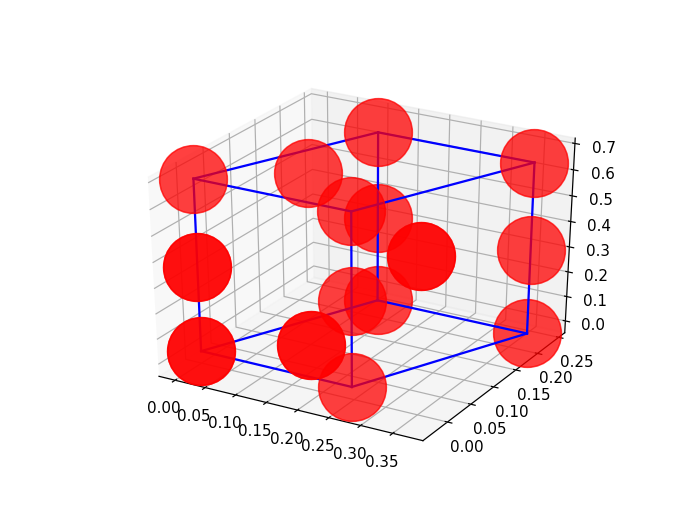

{'C': 'red'}


In [6]:
fig = plt.figure();ax = fig.add_subplot(111, projection='3d')
# draw unit_cell

a = tags['unit_cell'][0]
b = tags['unit_cell'][1]
c = tags['unit_cell'][2]

corners = [[0,0,0], a, a+b, b, c, c+a, c+a+b, c+b]
trace = [[0,1],[1,2],[2,3],[3,0], [0,4], [4,5], [5,6], [6,7], [7,4], [1,5], [2,6], [3,7]]
for s, e in trace:
    ax.plot3D(*zip(corners[s], corners[e]), color="blue")

    
# draw atoms
baseA = list(np.dot(tags['base'], tags['unit_cell']) )  # convert to a list of carthesian coordinates

#initialize lists and a dictionary
base = []
elements = []
colors = ['red', 'blue', 'green']
coloring = {}

# Add atoms that are 'on the other side' of the unit cell
j = 0
for i, atom in enumerate(baseA):
    base.append(atom)
    
    if tags['elements'][i] not in elements:
        coloring[tags['elements'][i]] = colors[j]
        j += 1
    elements.append(tags['elements'][i])
    for corner in corners:
        if np.dot(atom,corner) < 1e-15:
            base.append(atom+corner)
            elements.append(tags['elements'][i])
    
print(coloring)
base = np.array(base)
for i, atom in enumerate(base):
    ax.scatter(atom[0], atom[1], atom[2], c=coloring[elements[i]], alpha = 0.75, s=2000)

ax.axis('equal'); ax.set_aspect("equal");  plt.show()

<IPython.core.display.Javascript object>


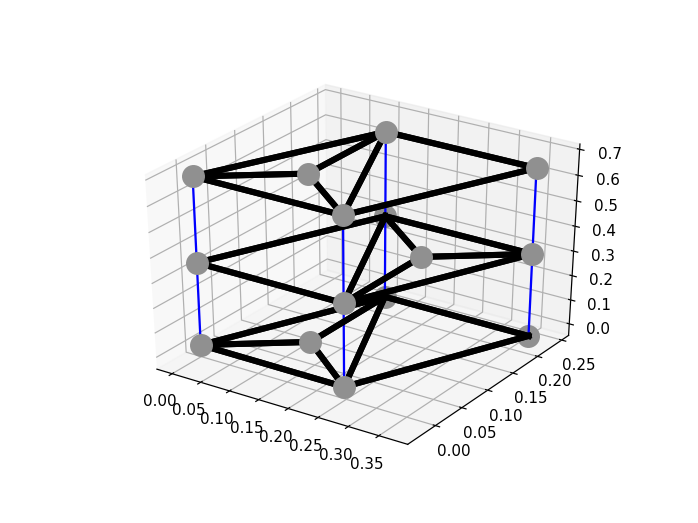

In [7]:
## alternatively we can use a function in KinsCat.
tags['max_bond_length'] = 0.25
ks.plot_unitcell(tags)

## May be with a few more atoms



<IPython.core.display.Javascript object>


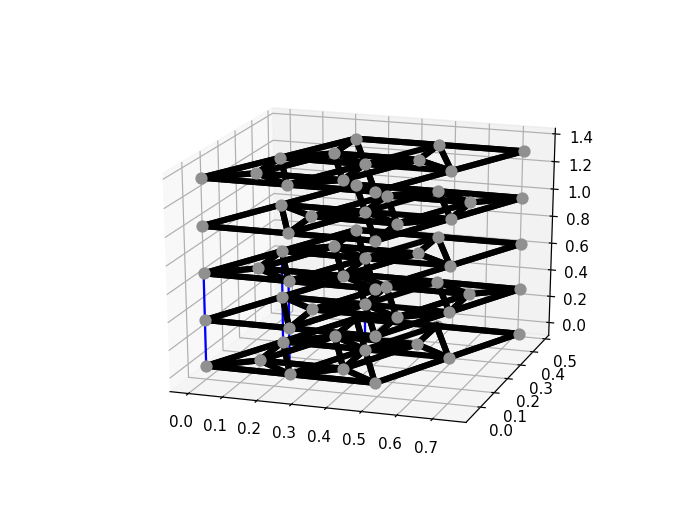

In [8]:
corners,balls, Z, bonds = ks.ball_and_stick(tags,extend=2, max_bond_length = 0.25)


fig = plt.figure();ax = fig.add_subplot(111, projection='3d')

# draw unit_cell
for x, y, z in corners:
    ax.plot3D( x,y,z, color="blue")

# draw bonds
for x, y, z in bonds:
    ax.plot3D( x,y,z, color="black", linewidth = 4)#, tube_radius=0.02)

# draw atoms
for i,atom in enumerate(balls):
    ax.scatter(atom[0],atom[1],atom[2],
              color=tuple(ks.jmol_colors [Z[i]]),
              alpha = 1.0, s=50)

ax.axis('equal'); ax.set_aspect("equal");  plt.show()

Okay, the above plot is not very beautiful.

If you use the **ase** or **mayavi** package, you can make nicer plots.

Please see:
[Plot Unit Cell with Other Packages](Plot_UnitCell.ipynb)


## Reciprocal Lattice 
The unit cell in reciprocal space

In [9]:
reciprocal_lattice = np.linalg.inv(tags['unit_cell']).T # transposed of inverted unit_cell
tags['reciprocal_lattice'] = reciprocal_lattice

print('reciprocal lattice [1/nm]:')
print(np.round(reciprocal_lattice,4))

reciprocal lattice [1/nm]:
[[ 4.0584 -2.3431  0.    ]
 [ 0.      4.6863  0.    ]
 [-0.     -0.      1.4901]]


## Reciprocal Lattice Vectors
From your crystallography book and lecture you are probably used to the following expression for the reciprocal lattice vectors ($\vec{a}^*, \vec{c}^*, \vec{c}^*$)

$ \begin{align}
  \vec{a}^* &=  \frac{\vec{b} \times \vec{c}}{\vec{a} \cdot \left(\vec{b} \times \vec{c}\right)} \\
  \vec{b}^* &=  \frac{\vec{c} \times \vec{a}}{\vec{b} \cdot \left(\vec{c} \times \vec{a}\right)} \\
  \vec{c}^* &=  \frac{\vec{a} \times \vec{b}}{\vec{c} \cdot \left(\vec{a} \times \vec{b}\right)}
\end{align}$\

Where we see that the denominators of the above vector equations are the volume of the unit cell.

In physics book, you will see an additional factor of 2$\pi$, which is generally omitted in materials science and microscopy.

In [10]:
## Now let's test whether this is really equivalent to the matrix expression above.

a_recip = np.cross(b,c)/np.dot(a,np.cross(b,c))
print (np.round(a_recip,3))
b_recip = np.cross(c,a)/np.dot(a,np.cross(b,c))
print (np.round(b_recip,3))
c_recip = np.cross(a,b)/np.dot(a,np.cross(b,c))
print (np.round(c_recip,3))
print('Compare to:')
print(np.round(reciprocal_lattice,3))

[ 4.058 -2.343  0.   ]
[0.    4.686 0.   ]
[-0.   -0.    1.49]
Compare to:
[[ 4.058 -2.343  0.   ]
 [ 0.     4.686  0.   ]
 [-0.    -0.     1.49 ]]


## Conclusion

With these definitions we have everything to define a crystal and to analyse diffraction and imaging data of crystalline specimens.

Crystallography deals with the application of symmetry and group theory of symmetry to crystal structures.
If you want to play around with symmetry and space groups, you can install the [spglib](http://atztogo.github.io/spglib/python-spglib.html#python-spglib). The spglib is especially helpfull for determination of reduced unit cells (the smallest possible ones, instead of the ones with the full symmetry).

A number of common crystal structures are defined in the KinsCat libary under the function ''structure_by_name''. Try them out in this notebook.

In [11]:
# As ususal the help function will show you the usage of a function:
help(ks.structure_by_name)

Help on function structure_by_name in module pyTEMlib.KinsCat:

structure_by_name(crystal)
    Provides unit cell as a structure matrix, the list of elements and the atom base
    
    Input:
    ------
        crystal name as string:
        type "print(ks.crystal_data_base.keys())" for a list of pre-defined crystal structures
    
        Please note that the chemical expressions are case sensitive.
    
    Ouput:
    ------
        new dictionary with the following keys:
        
        ['unit_cell']: the structure matrix
        ['base']:      relative coordinates of atoms
        ['elements']:     name of elements in same order as base
    
        an empty dictionary will be returned if the name is not recognized.



In [12]:
print(ks.crystal_data_base.keys())

dict_keys(['aluminum', 'Al', 'Aluminum', 'gold', 'Au', 'Gold', 'silver', 'Ag', 'Silver', 'diamond', 'Diamond', 'germanium', 'Ge', 'Germanium', 'silicon', 'Si', 'Silicon', 'GaAs', 'FCC Fe', 'fcc fe', 'BCC Fe', 'bcc fe', 'SrTiO3', 'ZnO Wurzite', 'ZnO', 'ZnO wurzite', 'wZnO', 'GaN', 'GaN wurzite', 'wGaN', 'GaN Wurzite', 'MgO', 'MoS2', 'WS2', 'WSe2', 'MoSe2', 'ZnO hexagonal', 'Graphite', 'graphite', 'CsCl', 'PdSe2'])


Now use one name of above structures and redo this notebook

## Back: [Atomic Form Factor](CH2-Atomic_Form_Factor.ipynb)
## Next: [Structure Factors](CH2-Structure_Factors.ipynb)
## Chapter 2: [Diffraction](CH2-_Diffraction.ipynb)
## List of Content: [Front](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)
